# Quickstart

This notebook is intended to demonstrate the basic usage of `superscreen` by calculating the magnetic response of several simple single-layer devices.

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16

import superscreen as sc

## Device geometry and materials

- **Layers** represent different physical planes in a device. All superconducting films in a given layer
  are assumed to have the same thickness and penetration depth.
- **Films** represent the actual superconducting films, which may fill only part of the `Layer` that they are in,
  and may have one or more holes. Each film can have an arbitrary polygonal geometry, and there can be multiple         (non-overlapping) films per layer.
- **Holes** are polygonal regions of vacuum completely surrounded (in 2D) by a superconducting film, which can contain   trapped flux.
- **Abstract regions** are polygonal regions which need not represent any real geometry in the device.   Abstract regions will be meshed just like films and holes, and after solving a `Device`, one can calculate the flux through all abstract regions. Abstract regions can be used to define a "bounding box," a region of vacuum outside of the convex hull of all the films that will be meshed and simulated.

## Superconducting disk

Here we define a superconducting disk of radius 4 $\mu$m with London penetration depth $\lambda=100$ nm and a thickness $d=25$ nm, for an effective penetration depth of $\Lambda=\lambda^2/d=400$ nm.

In [2]:
length_units = "um"

layers = [
    sc.Layer("base", london_lambda=0.1, thickness=0.025, z0=0),
]

films = [
    sc.Polygon("disk", layer="base", points=sc.geometry.circle(4, points=400)),
]

holes = []

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=sc.geometry.circle(5.5, points=100)),
]

device = sc.Device(
    "disk",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [3]:
print(device)

Device(
    "disk", 
    layers=[
        Layer("base", Lambda=0.400, thickness=0.025, london_lambda=0.100, z0=0.000),
    ], 
    films=[
        Polygon(name="disk", layer="base", points=<ndarray: shape=(401, 2)>, mesh=True),
    ], 
    holes=None, 
    abstract_regions=[
        Polygon(name="bounding_box", layer="base", points=<ndarray: shape=(101, 2)>, mesh=True),
    ], 
    length_units="um",
)


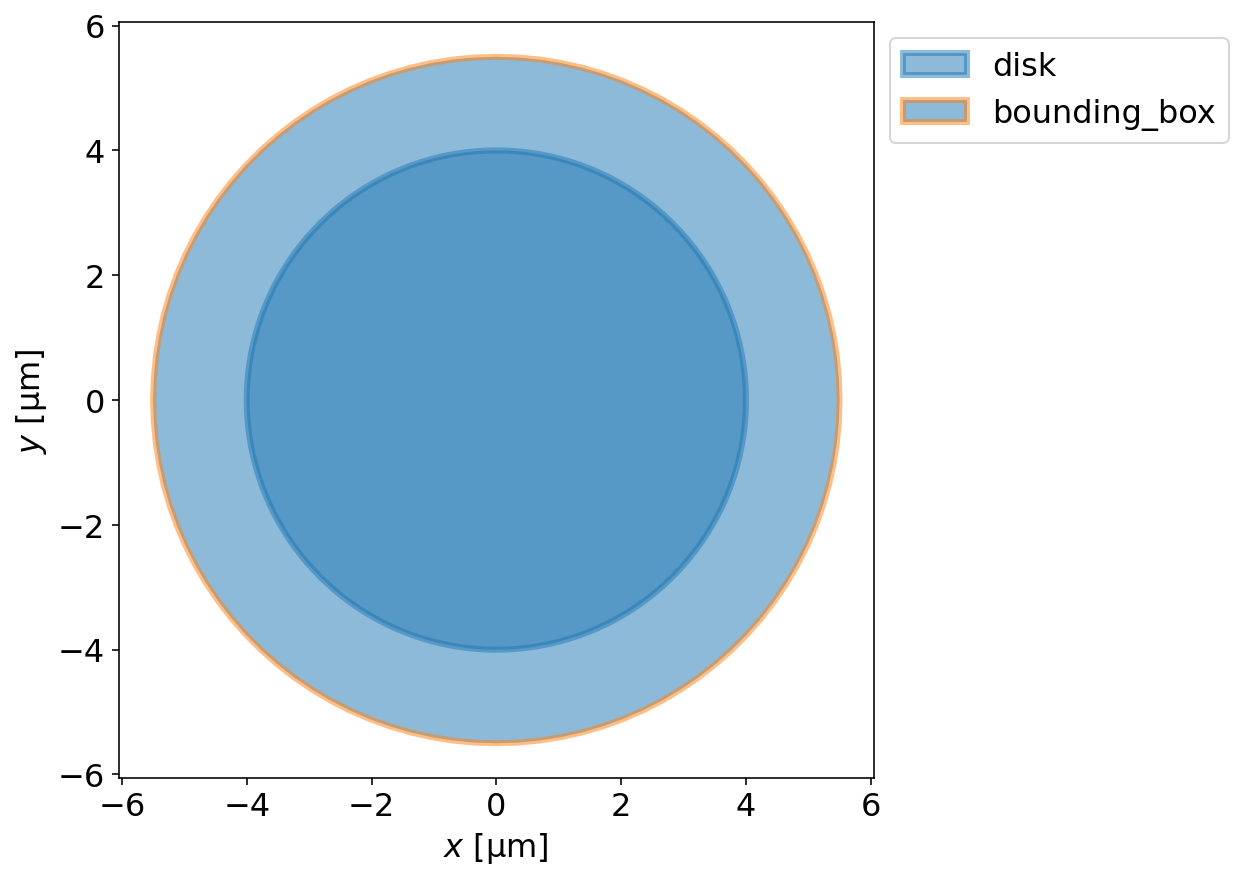

In [4]:
fig, ax = device.draw()

### Generate the mesh

In [5]:
device.make_mesh(min_triangles=8_000, optimesh_steps=20)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 8022 triangles.
INFO:superscreen.device.device:Finished generating mesh with 4072 points and 8022 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.


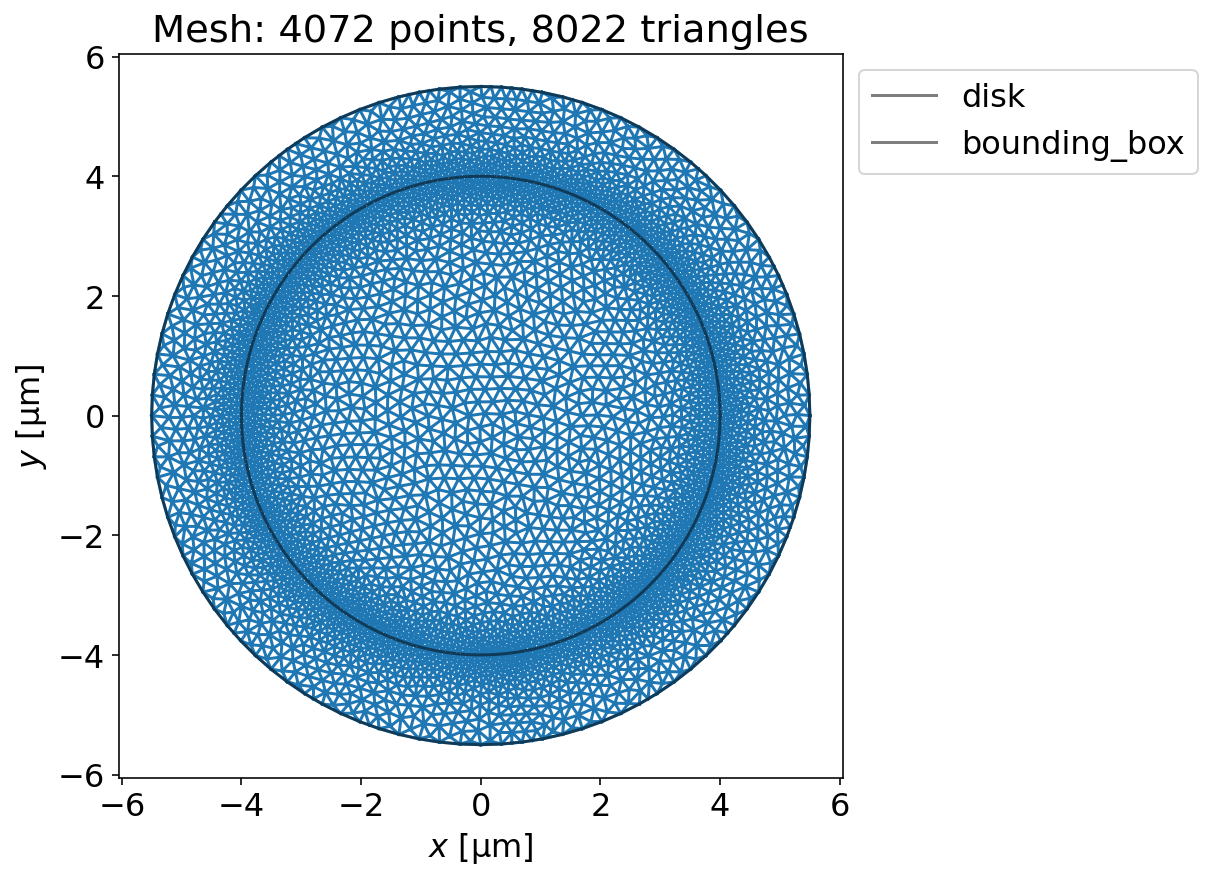

In [6]:
fig, ax = device.plot(color='k', alpha=0.5, mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Simulate Meissner screening

Here we apply a uniform field field in the $+z$ direction and calculate the disk's magnetic response.

In [7]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="mT",
    current_units="mA",
)
assert len(solutions) == 1
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


In [8]:
xs = np.linspace(-5, 5, 401)

cross_section_coords = [
    # [x-coords, y-coords]
    np.stack([xs, xs], axis=1) / np.sqrt(2), # diagonal cross-section
    np.stack([xs, 3 * np.ones_like(xs)], axis=1), # horizontal cross-section
]

#### Visualize the fields

We expect to see only the applied field far outside the disk, approximately 0 $\mu$T inside the disk, and a sharp peak just outside the disk due to Meissner screening.

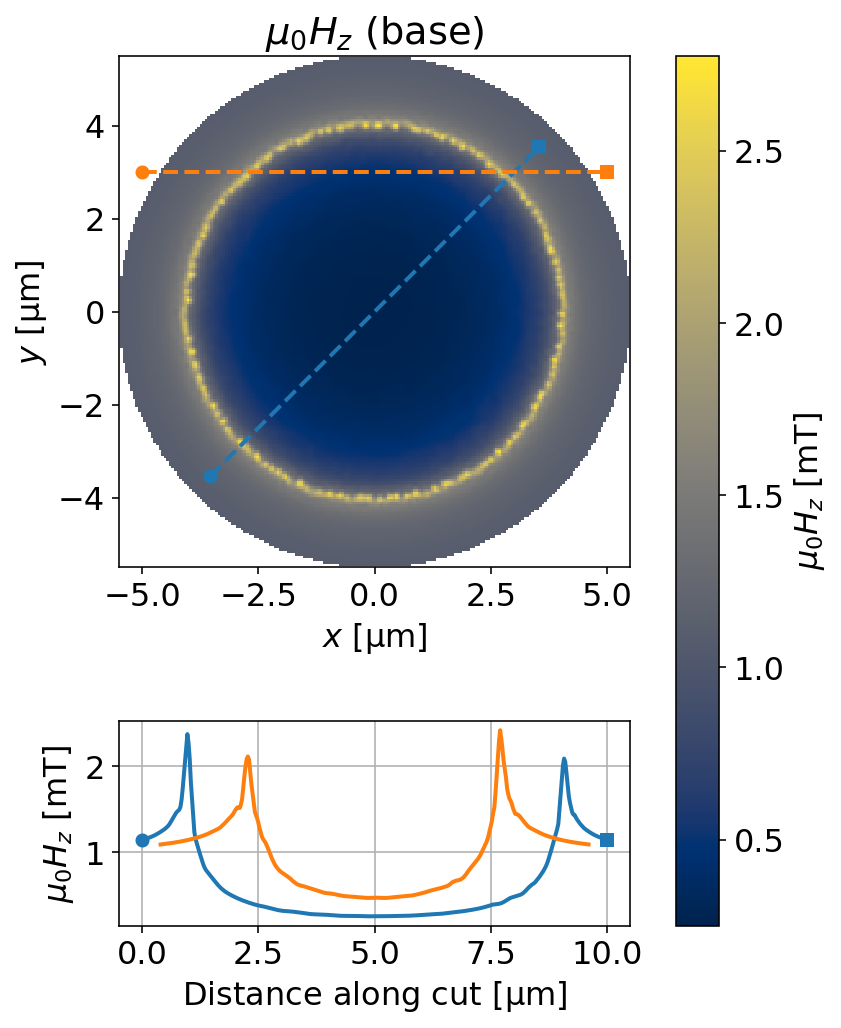

In [9]:
fig, axes = solution.plot_fields(cross_section_coords=cross_section_coords, figsize=(6, 8))

#### Visualize the currents

We expect to see counterclockwise circulating current in the disk, which generates a screening field in the $-z$ direction to cancel the field applied in the $+z$ direction.

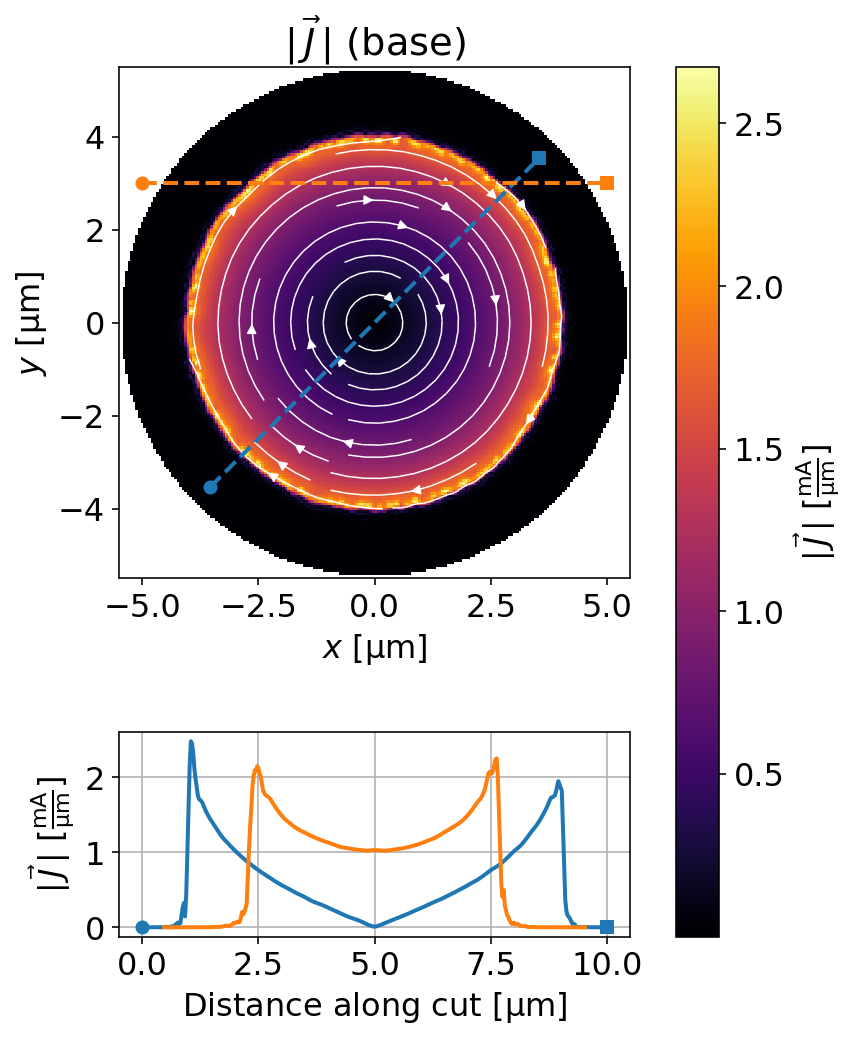

In [10]:
fig, axes = solution.plot_currents(
    units="mA/um",
    cross_section_coords=cross_section_coords,
    figsize=(6, 8),
)

## Superconducting ring

Let's see what happens if we add a hole to our device (making it a ring or washer).

In [11]:
holes = [
    sc.Polygon("hole", layer="base", points=sc.geometry.circle(2))
]

device = sc.Device(
    "ring",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

In [12]:
device.make_mesh(min_triangles=8_000, optimesh_steps=20)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 8005 triangles.
INFO:superscreen.device.device:Finished generating mesh with 4055 points and 8005 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.


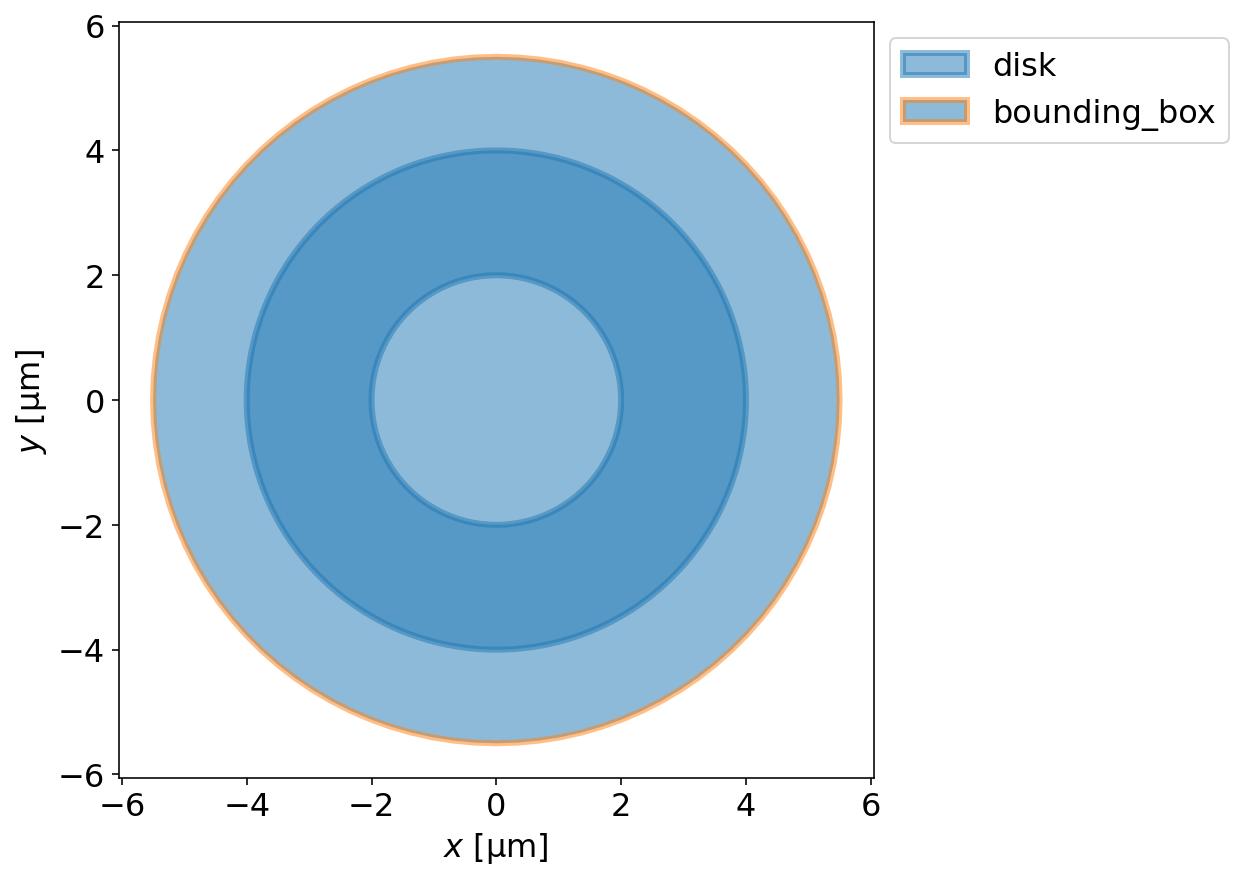

In [13]:
fig, ax = device.draw()

In [14]:
fig, ax = device.plot(ax=ax, color='k', alpha=0.5, mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Uniform applied field

First, let's look at the response of the ring to the same uniform field that we applied to the [disk](#Superconducting-disk) above (assuming no flux trapped in the center of the ring).

In [15]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    field_units="mT",
    current_units="mA",
)
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


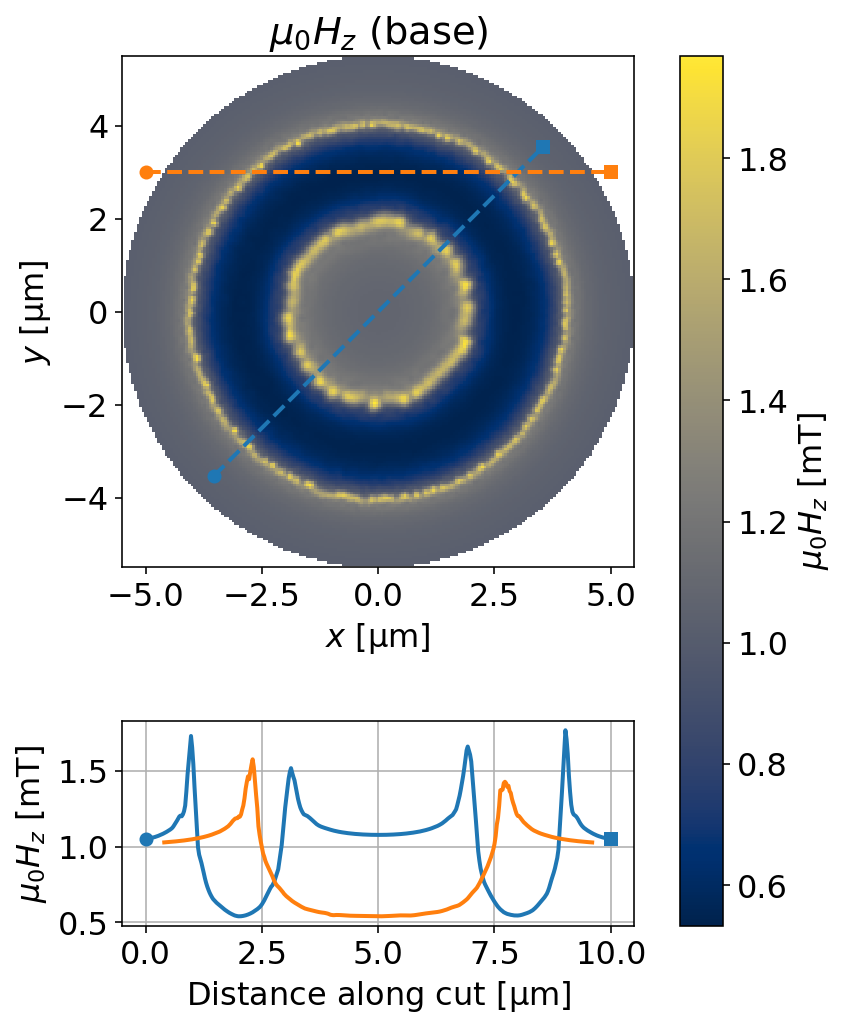

In [16]:
fig, axes = solution.plot_fields(cross_section_coords=cross_section_coords, figsize=(6, 8))

Note that, in contrast with the full [disk](#Superconducting-disk), the screening currents are flowing in opposite directions in the inner and outer areas of the ring.

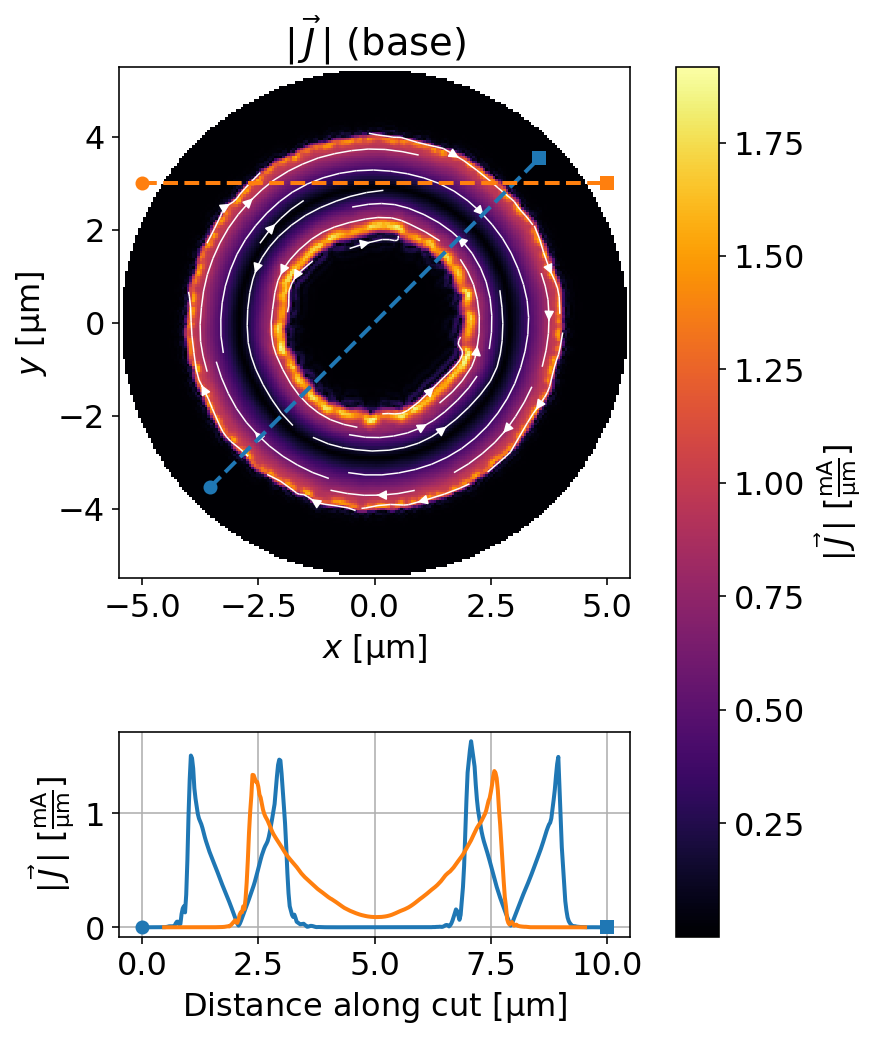

In [17]:
fig, axes = solution.plot_currents(
    units="mA/um",
    cross_section_coords=cross_section_coords,
    figsize=(6, 8)
)

### Trapped flux

We can also solve for the field and current distribution from circulating currents associated with flux trapped in the hole.

We assume there is a total current of 1 $\mu$A circulating clockwise in the ring (associated with some positive net trapped flux), and that there is otherwise no applied magnetic field. From here we can calculate the current distribution in the ring, the total magnetic field in the plane of the ring, and the flux through the ring.

Note that, although here we are assuming no applied field, we can also solve models with both trapped flux and applied fields.

In [18]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole": "1 mA",
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="mA",
)
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


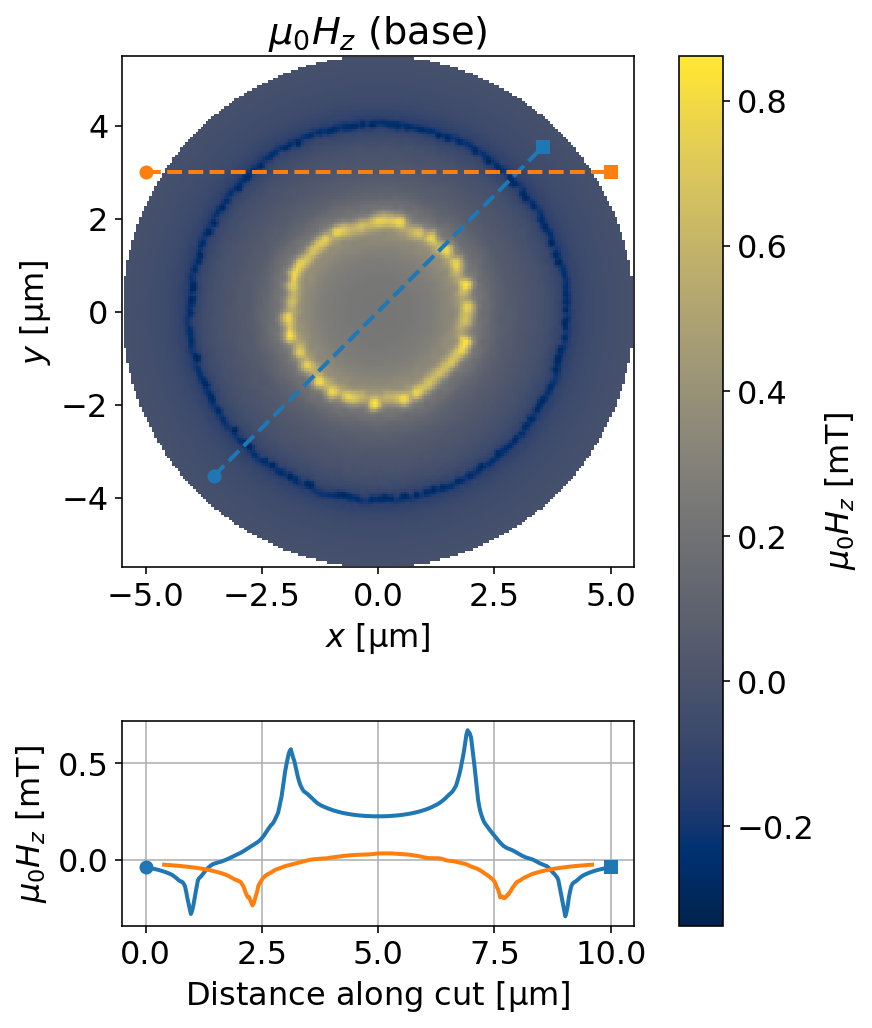

In [19]:
fig, axes = solution.plot_fields(cross_section_coords=cross_section_coords, figsize=(6, 8))

### Verify the circulating current by integrating the current density $\vec{J}$

x cut, total current: 0.99963 mA (error = 0.037%)
y cut, total current: 1.00065 mA (error = 0.065%)


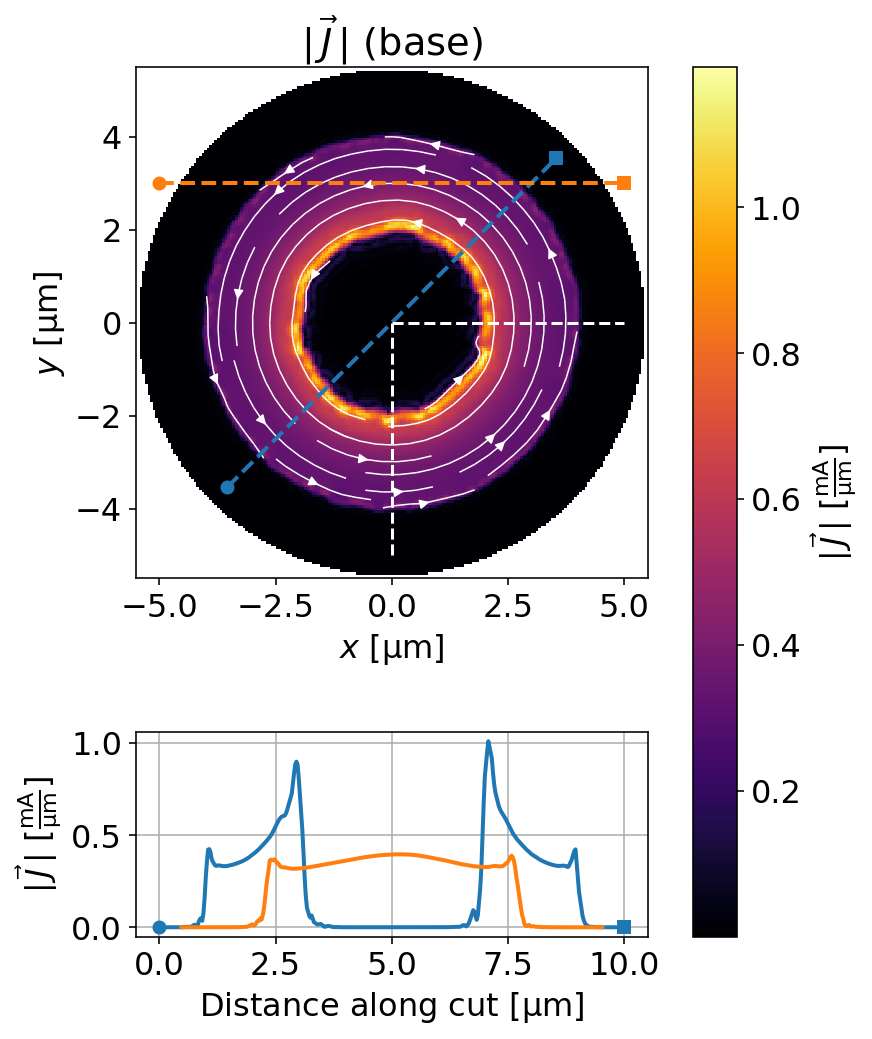

In [20]:
fig, axes = solution.plot_currents(
    units="mA/um",
    cross_section_coords=cross_section_coords,
    figsize=(6, 8),
)

# horizontal cut
xs = np.linspace(0, 5, 101)
xcut = np.stack([xs, 0 * xs], axis=1)
# vertical cut
ys = np.linspace(-5, 0, 101)
ycut = np.stack([0 * ys, ys], axis=1)

for i, (cut, label, axis) in enumerate(zip((xcut, ycut), "xy", (1, 0))):
    # Plot the cut coordinates on the current plot
    for ax in axes:
        ax.plot(cut[:, 0], cut[:, 1], "w--")
    # Evaluate the current density at the cut coordinates
    j_interp = solution.interp_current_density(
        cut, units="mA / um", with_units=False
    )["base"]
    # Integrate the approriate component of the current density
    # along the cut to get the total circulating current.
    I_tot = np.trapz(j_interp[:, axis], x=cut[:, i])
    I_target = 1 # mA
    print(
        f"{label} cut, total current: {I_tot:.5f} mA "
        f"(error = {100 * abs((I_tot - I_target) / I_target):.3f}%)"
    )

### Calculate the fluxoid, and self-inductance

The self-inductance of a superconducting loop with a hole $h$ is given by

$$
L = \frac{\Phi_h^f}{I_h},
$$

where $I_h$ is the current circulating around the hole and $\Phi_h^f$ is the fluxoid for a path enclosing the hole. The fluxoid $\Phi^f_S$ for a 2D region $S$ with 1D boundary $\partial S$ is given by the sum of flux through $S$ and the line integral of sheet current around $\partial S$:

$$
    \Phi^f_S = \underbrace{\int_S\mu_0H_z(\vec{r})\,\mathrm{d}^2r}_\text{''flux part''} + \underbrace{\oint_{\partial S}\mu_0\Lambda(\vec{r})\vec{J}(\vec{r})\cdot\mathrm{d}\vec{r}}_\text{''supercurrent part''}.
$$

The method `Solution.polygon_fluxoid()` calculates the fluxoid for an arbitrary closed region in a `Device`, and the method `Solution.hole_fluxoid()` calculates the fluxoid for a given hole in a `Device` (automatically generating an appropriate integration region $S$ if needed).

In [21]:
region = sc.geometry.circle(2.5, points=301)
fluxoid = solution.polygon_fluxoid(region)["base"]
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(3.02654414, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(2.06699065, 'magnetic_flux_quantum')>)
The total fluxoid is: 5.094 Φ_0


In [22]:
hole_name = list(device.holes)[0]
fluxoid = solution.hole_fluxoid(hole_name)
print(fluxoid)
print(f"The total fluxoid is: {sum(fluxoid):~.3fP}")

Fluxoid(flux_part=<Quantity(3.3109892, 'magnetic_flux_quantum')>, supercurrent_part=<Quantity(1.78367724, 'magnetic_flux_quantum')>)
The total fluxoid is: 5.095 Φ_0


In [23]:
I_circ = device.ureg(circulating_currents["hole"])
L = (sum(fluxoid) / I_circ).to("Phi_0 / A")
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

The ring's self-inductance is 5094.666 Φ_0/A = 10.535 pH.


For a device with $N$ holes, there are $N^2$ mutual inductances between them. This mutual inductance matrix is given by:

$$
M_{ij}=\frac{\Phi_i^f}{I_j},
$$

where $\Phi_i^f$ is the fluxoid for a region enclosing hole $i$ and $I_j$ is the current circulating around hole $j$. Note that the mutual inductance matrix is symmetric: $M_{ij}=M_{ji}$. The diagonals of the mutual inductance matrix are the hole self-inductances: $M_{ii} = L_i$, the self-inductance of hole $i$.

The above process of modeling a circulating current for each hole, calculating the fluxoid, and extracting the inductance is automated in the method `Device.mutual_inductance_matrix()`. In this case, for our device with a single hole, the mutual inductance matrix will be a `1\times1` matrix containing only the self-inductance $L$.

In [24]:
M = device.mutual_inductance_matrix(units="Phi_0 / A")
print(f"Mutual inductance matrix shape:", M.shape)
L = M[0, 0]
print(f"The ring's self-inductance is {L:.3f~P} = {L.to('pH'):~.3fP}.")

INFO:superscreen.device.device:Evaluating 'ring' mutual inductance matrix column (1/1), source = 'hole'.
INFO:superscreen.solve:Calculating base response to applied field.


Mutual inductance matrix shape: (1, 1)
The ring's self-inductance is 5094.666 Φ_0/A = 10.535 pH.


## Film with multiple holes

Here we simulate a device with fewer symmetries than the disk or ring, namely a rectangular film with two off-center rectangular holes.

In [25]:
length_units = "um"

layers = [
    sc.Layer("base", Lambda=0.1, z0=0),
]

films = [
    sc.Polygon("film", layer="base", points=sc.geometry.box(8, 4)),
]

holes = [
    sc.Polygon(
        "hole0",
        layer="base",
        points=sc.geometry.box(5, 1, center=(0.5, -0.25))
    ),
    sc.Polygon(
        "hole1",
        layer="base",
        points=sc.geometry.box(1, 2.5, center=(-3, 0.25))
    ),
]

abstract_regions = [
    sc.Polygon("bounding_box", layer="base", points=sc.geometry.box(9, 5)),
]

device = sc.Device(
    "rect",
    layers=layers,
    films=films,
    holes=holes,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

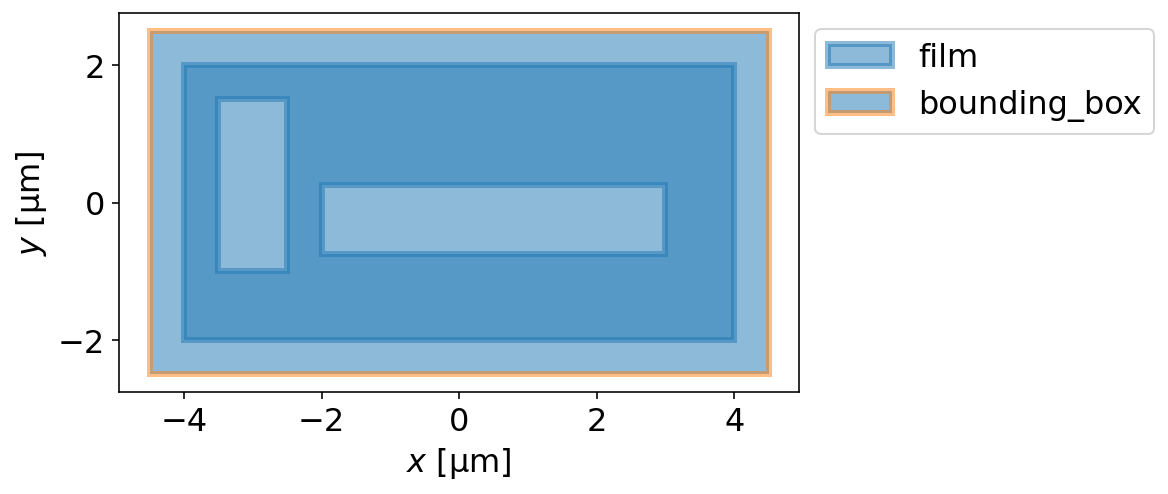

In [26]:
fig, ax = device.draw()

In [27]:
device.make_mesh(min_triangles=8_000)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 4292 points and 8328 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.


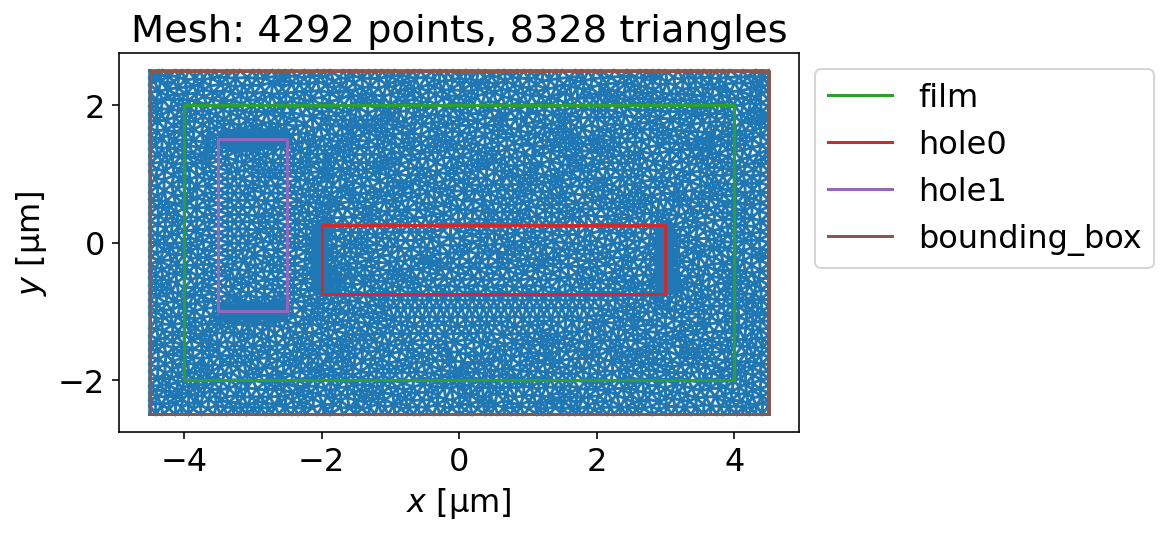

In [28]:
fig, ax = device.plot(mesh=True)
_ = ax.set_title(
    f"Mesh: {device.points.shape[0]} points, "
    f"{device.triangles.shape[0]} triangles"
)

### Uniform field

Here we apply the same uniform field as we did to the [disk](#Simulate-Meissner-screening) and [ring](#Uniform-applied-field), assuming no trapped flux in either hole.

In [29]:
applied_field = sc.sources.ConstantField(1)

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=None,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


In [30]:
cross_section_coords = [
    np.stack([np.linspace(-4.5, 4.5, 401), y * np.ones(401)], axis=1)
    for y in (0, 1, 1.75)
]

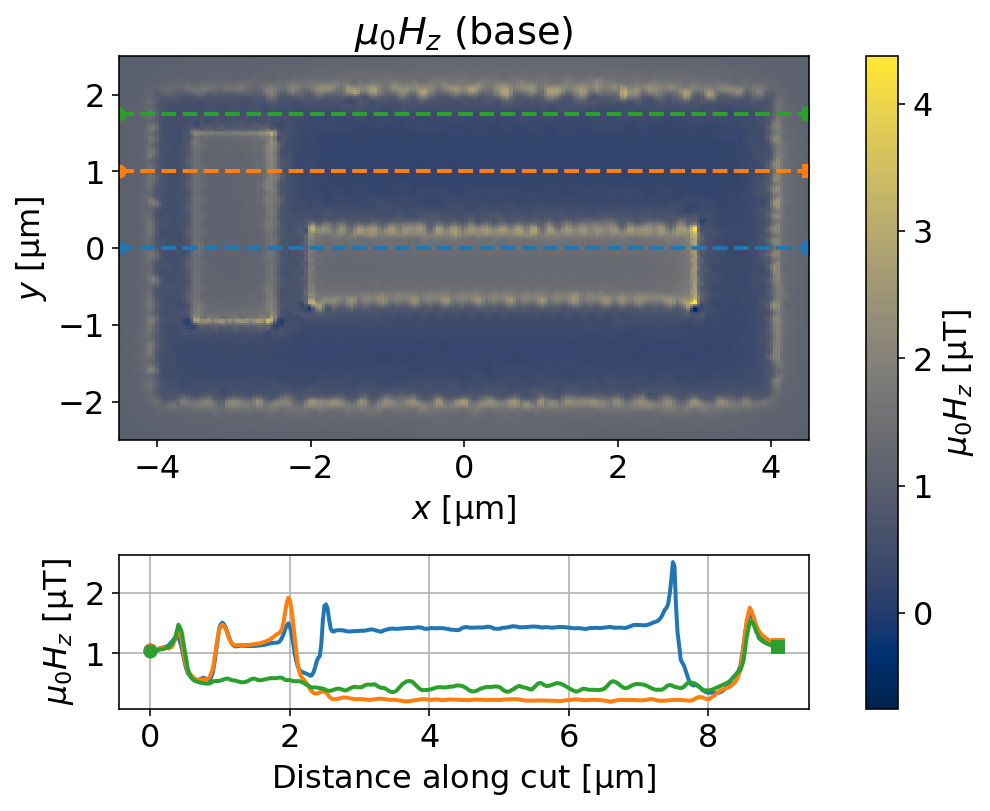

In [31]:
fig, axes = solution.plot_fields(
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

In [32]:
cross_section_coords = [
    np.stack([np.linspace(-4.5, 4.5, 401), y * np.ones(401)], axis=1)
    for y in (-1.1, 0, 1.1)
]

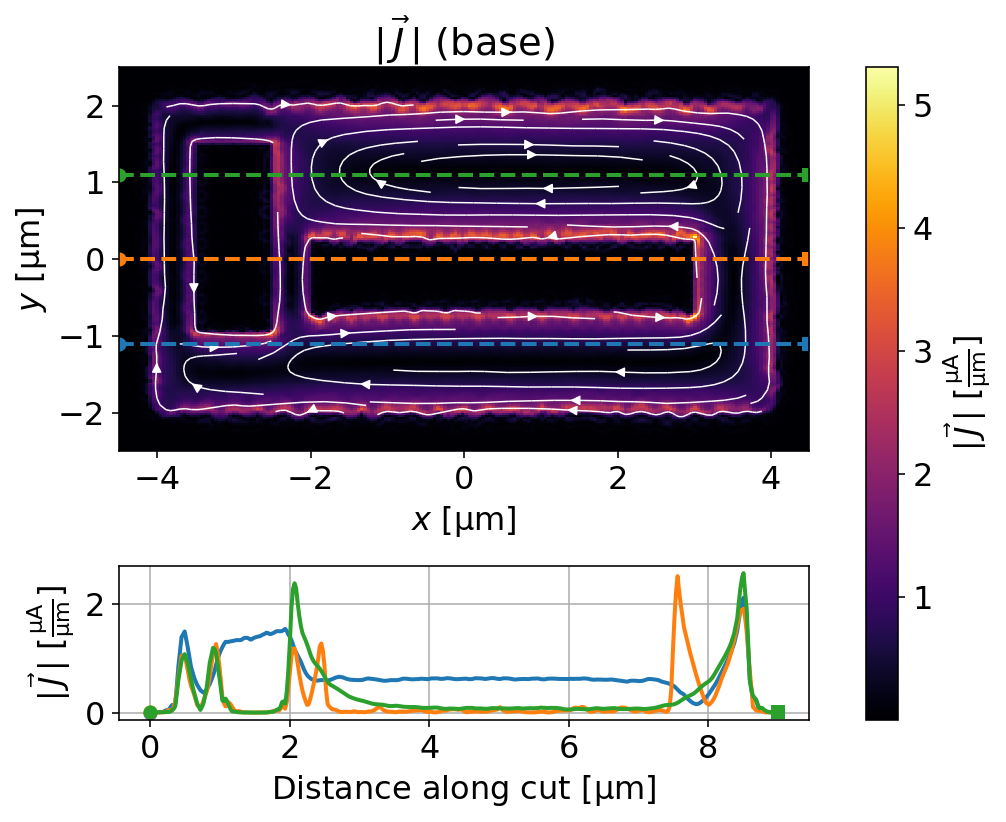

In [33]:
fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in one hole

INFO:superscreen.solve:Calculating base response to applied field.


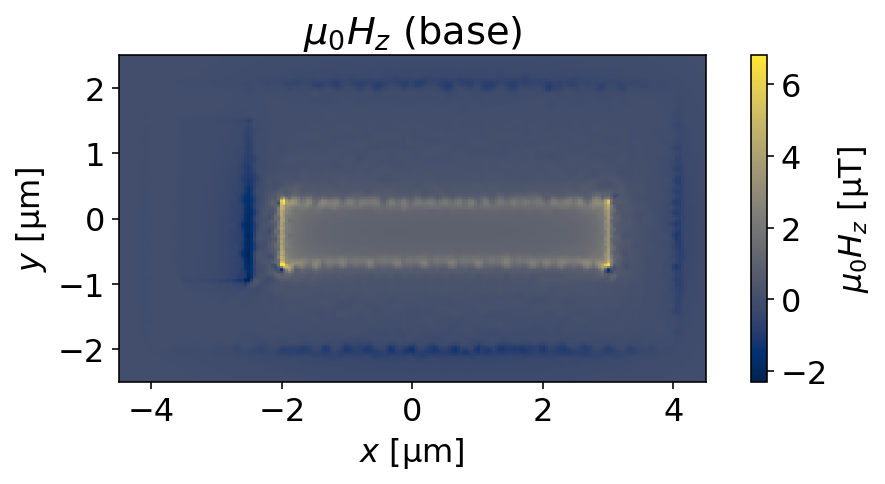

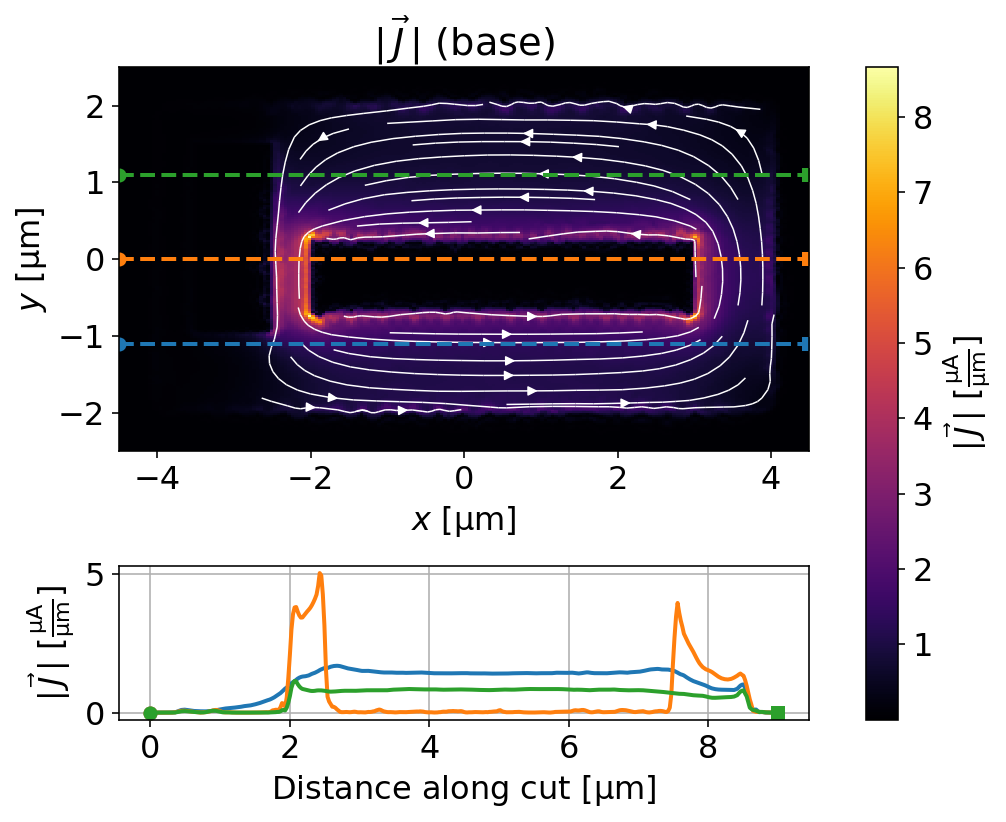

In [34]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "2 uA",
    "hole1": "0 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(
    figsize=(8, 3),
)

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in the other hole

INFO:superscreen.solve:Calculating base response to applied field.


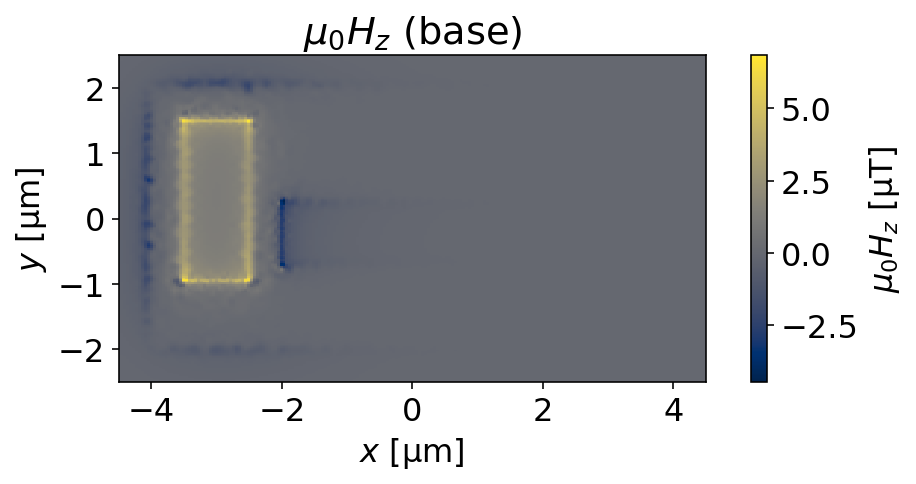

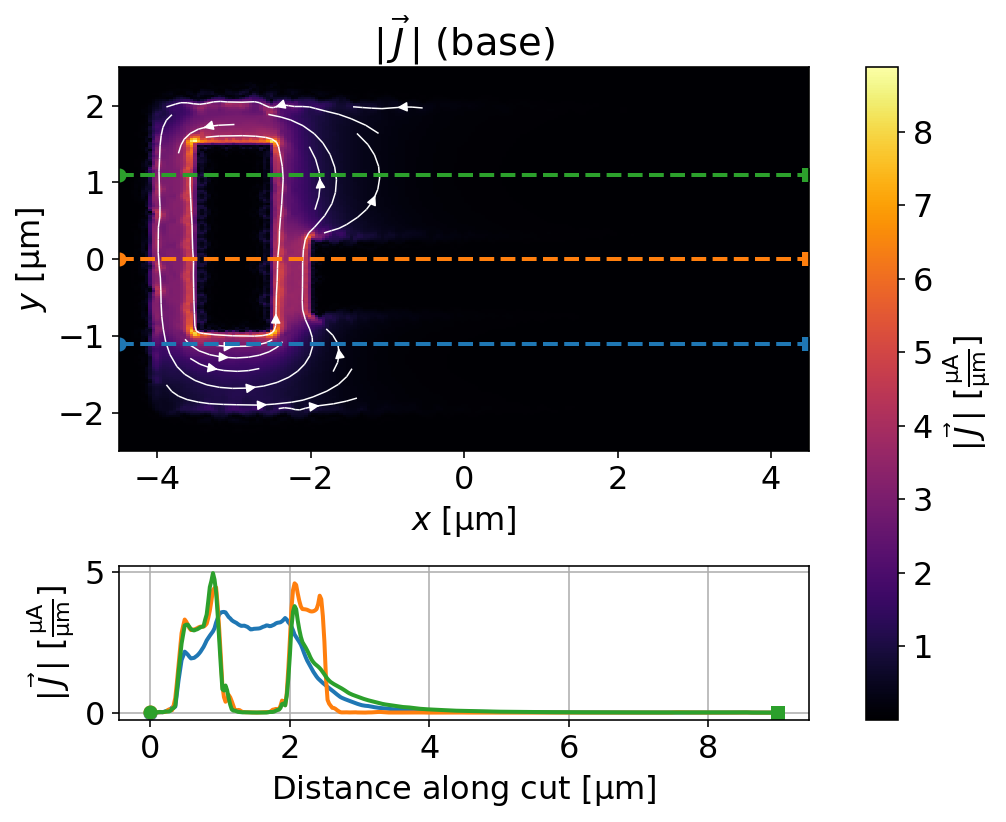

In [35]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "0 uA",
    "hole1": "2 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(
    figsize=(8, 3),
)

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Trapped flux in both holes

INFO:superscreen.solve:Calculating base response to applied field.


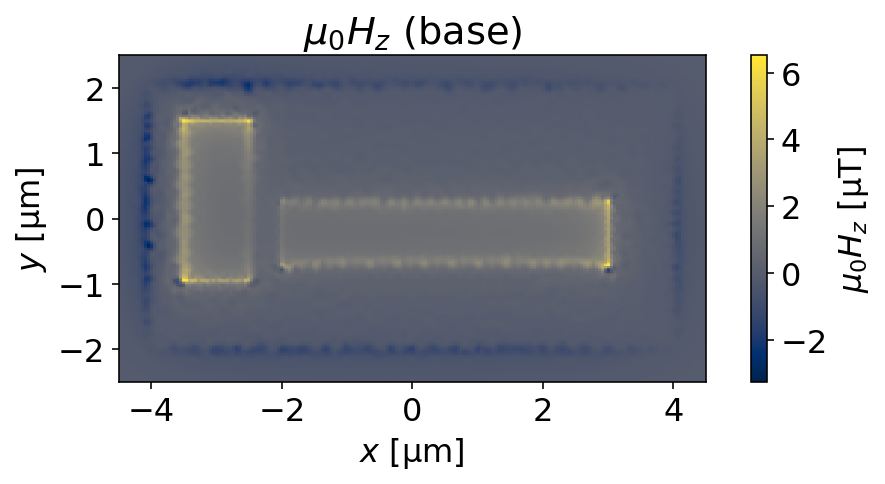

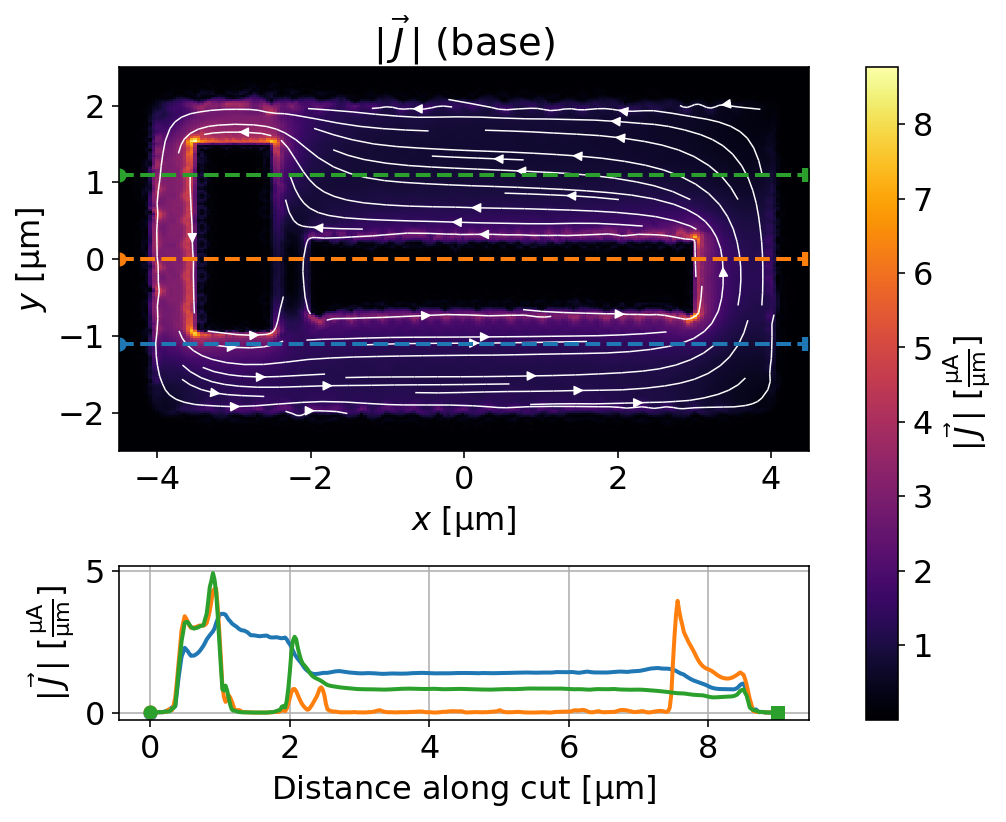

In [36]:
applied_field = sc.sources.ConstantField(0)

circulating_currents = {
    "hole0": "2 uA",
    "hole1": "2 uA"
}

solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="uT",
    current_units="uA",
)
solution = solutions[-1]

fig, axes = solution.plot_fields(figsize=(8, 3))

fig, axes = solution.plot_currents(
    units="uA/um",
    cross_section_coords=cross_section_coords,
    figsize=(8, 6),
)

### Full mutual inductance matrix

In [37]:
M = device.mutual_inductance_matrix(units="pH")
print(f"Mutual inductance matrix shape:", M.shape)
display(M)

INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (1/2), source = 'hole0'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating 'rect' mutual inductance matrix column (2/2), source = 'hole1'.
INFO:superscreen.solve:Calculating base response to applied field.


Mutual inductance matrix shape: (2, 2)


Magnitude,[[6.040552483331118 -0.8700454690866144] [-1.0052912528090532 4.841135536431174]]
Units,picohenry


As promised, the mutual inductance matrix is approximately symmetric:

In [38]:
asymmetry = float(np.abs((M[0, 1] - M[1, 0]) / min(M[0, 1], M[1, 0])))
print(f"Mutual inductance matrix fractional asymmetry: {100 * asymmetry:.3f}%")

Mutual inductance matrix fractional asymmetry: 13.453%


### Non-uniform applied field

So far we have only seen uniform applied fields. Here we demonstrate how to model an inhomogenous applied field.

We will use a superposition of isolated vortices, each located at position $\vec{r}_i=(x_i, y_i, z_i)$:

$$\mu_0H_z(\vec{r}) = \mu_0H_z(x, y, z) = \sum_i \frac{1}{2\pi}\frac{(\vec{r}-\vec{r}_i)\cdot\hat{z}}{|\vec{r}-\vec{r}_i|^{3}}$$

In [39]:
def vortex_field(x, y, z, vortex_position=(0, 0, 0), nPhi0=1):
    """The field from an isolated vortex pinned in a bulk superconductor.

    Args:
        x, y, z: Position coordinates.
        vortex_position: (x, y, z) position of the vortex.
        nPhi0: Number of flux quanta contained in the vortex.
        
    Returns:
        Magnetic field in units of Phi_0 / (length_units)^2,
        where length_units are the units of x, y, z, etc.
    """
    xv, yv, zv = vortex_position
    xp = x - xv
    yp = y - yv
    zp = z - zv
    Bz0 = zp / (xp ** 2 + yp ** 2 + zp ** 2) ** (3 / 2) / (2 * np.pi)
    return nPhi0 * Bz0

Define the applied field:

In [40]:
vortex_z = -0.4 # Vortices located in a plane 400 nm below our device
vortex_positions = [
    ( 0.0,  0.0),
    (-2.3, -0.5),
    ( 2.0,  1.0),
    ( 1.5, -0.3),
    ( 4.0, -2.0),
    (-3.0,  1.5),
    (-4.0,  0.0),
]

applied_field = sum(
    sc.Parameter(vortex_field, vortex_position=(x, y, vortex_z))
    for x, y in vortex_positions
)

# Or equivalently, use the built in VortexField source:
# applied_field = sum(
#     sc.sources.VortexField(x0=x, y0=y, z0=vortex_z)
#     for x, y in vortex_positions
# )

Solve the model:

In [41]:
solutions = sc.solve(
    device=device,
    applied_field=applied_field,
    circulating_currents=None,
    field_units="Phi_0/um**2",
    current_units="uA",
)
solution = solutions[-1]

INFO:superscreen.solve:Calculating base response to applied field.


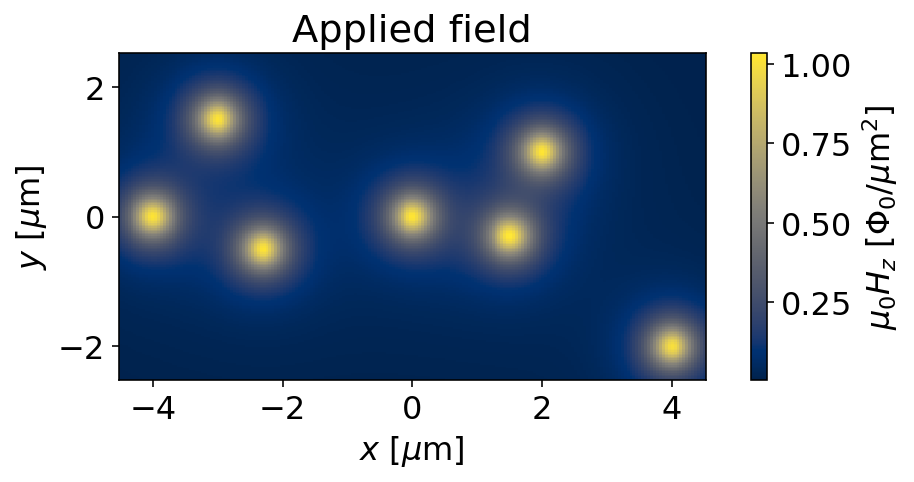

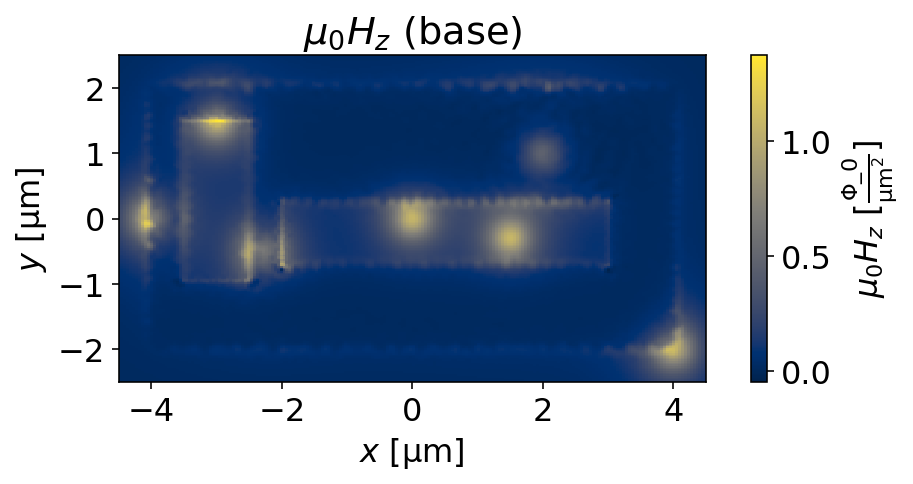

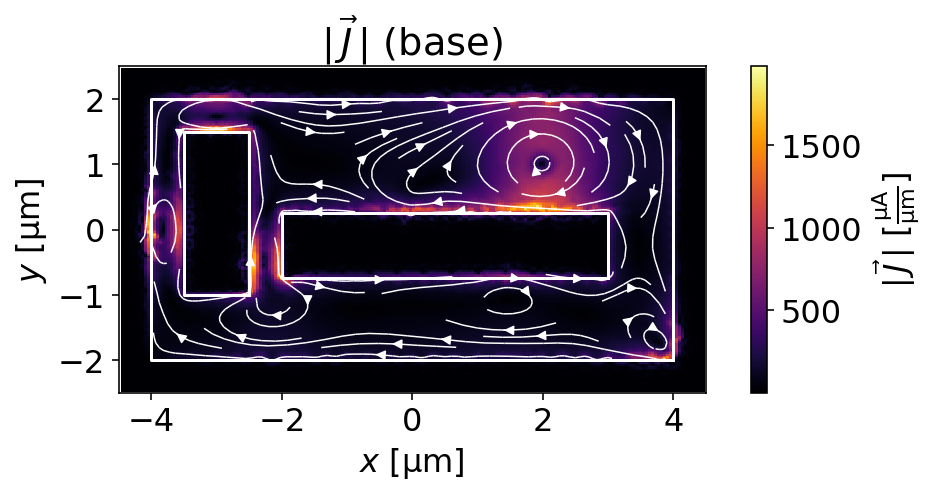

In [42]:
# Calculate and plot the applied field
xgrid, ygrid, _ = solution.grid_data("fields")
z = device.layers["base"].z0
Hz_applied = applied_field(xgrid, ygrid, z)

# Plot the applied field
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_aspect("equal")
ax.set_title("Applied field")
im = ax.pcolormesh(xgrid, ygrid, Hz_applied, cmap="cividis", shading="auto")
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$x$ [$\mu$m]")
ax.set_ylabel("$y$ [$\mu$m]")
cbar.set_label("$\mu_0H_z$ [$\Phi_0/\mu\mathrm{m}^2$]")

# Plot the total field and current
fig, axes = solution.plot_fields(figsize=(8, 3))
fig, axes = solution.plot_currents(units="uA/um", figsize=(8, 3))
fig, ax = device.plot(ax=axes[0], color='w', legend=False)

In [43]:
sc.version_table()

Software,Version
SuperScreen,0.1.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS
